In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import collections
import os
import random
from io import BytesIO
from uuid import uuid4

import diffusers
import einops
import PIL
import requests
import sh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.functional as TF
from attention_augmentation import collect_attention, replace_attention
from controlnet_aux import HEDdetector
from diffusers import (ControlNetModel, DDIMInverseScheduler, DDIMScheduler,
                       EulerAncestralDiscreteScheduler,
                       StableDiffusionControlNetPipeline,
                       StableDiffusionInpaintPipeline, StableDiffusionPipeline,
                       UniPCMultistepScheduler)
from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint import *
from diffusers.utils.torch_utils import randn_tensor
from einops import rearrange, repeat
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import sh
from utils import generate_circular_gradient, display_images
from PIL import ImageFilter

/home/robert/miniconda3/envs/ml23c/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [3]:
dt = torch.bfloat16

In [4]:
base_model = "Lykon/DreamShaper"
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_softedge", torch_dtype=dt).cuda()
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None, controlnet=controlnet, variant="bf16", torch_dtype=dt).to('cuda')
pipe.safety_checker = None

[p.requires_grad_(False) for p in [pipe.vae, pipe.unet, pipe.text_encoder, controlnet]];

/home/robert/miniconda3/envs/ml23c/lib/python3.10/site-packages/diffusers/pipelines/pipeline_utils.py:1223: FutureWarning: You are trying to load the model files of the `variant=bf16`, but no such modeling files are available.The default model files: {'safety_checker/pytorch_model.bin', 'text_encoder/pytorch_model.bin', 'unet/diffusion_pytorch_model.safetensors', 'vae/diffusion_pytorch_model.safetensors', 'text_encoder/model.safetensors', 'safety_checker/model.safetensors', 'vae/diffusion_pytorch_model.bin', 'unet/diffusion_pytorch_model.bin'} will be loaded instead. Make sure to not load from `variant=bf16`if such variant modeling files are not available. Doing so will lead to an error in v0.22.0 as defaulting to non-variantmodeling files is deprecated.
  deprecate("no variant default", "0.22.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `s

In [5]:
ts = 20
ddim_inv = DDIMInverseScheduler.from_config(pipe.scheduler.config)
ddim_fwd = DDIMScheduler.from_config(pipe.scheduler.config)
ddim_inv.set_timesteps(ts)
ddim_fwd.set_timesteps(ts)
# pipe.scheduler = EulerAncestralDiscreteScheduler().from_config(pipe.scheduler.config) #ddim_fwd
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(ts)

In [6]:
frame_shape = (512, 512)
sh.mkdir('-p', 'frames')
sh.ffmpeg("-i", "original.mp4", "-vf", f"crop=512:512:(in_w-512)/2:(in_h-512)/2", "-r", "15", f"frames/%04d.png")
frames = [Image.open(x).resize(frame_shape, Image.LANCZOS) for x in sorted([f'frames/{x}' for x in os.listdir('frames')])]
# frames = [f.filter(ImageFilter.GaussianBlur(radius = 25)) for f in frames[0:10]]
frames = frames[0:10]
prompt = "Man shaving wood flakes"

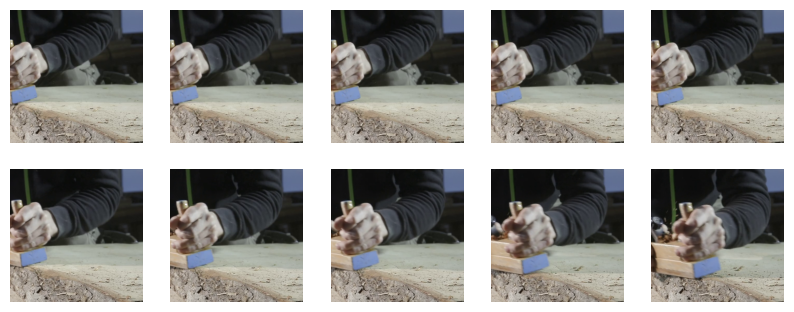

In [7]:
display_images(frames)

In [9]:
def latents_to_img(latents):
	decoded = pipe.vae.decode(latents.unsqueeze(0) / pipe.vae.config.scaling_factor)[0].squeeze()
	return TF.to_pil_image((decoded / 2 + 0.5).clamp(0, 1))

In [10]:
def frame_to_tensor(image):
	return TF.pil_to_tensor(image).to(dt).cuda() / 256

In [11]:
preprocess = HEDdetector.from_pretrained('lllyasviel/Annotators')
preprocessed_frames = [TF.pil_to_tensor(preprocess(f).resize(frame_shape)).to(dt) / 256 for f in tqdm(frames)]

100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


In [12]:
class SaveAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.history = []

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs)
		self.history.append(out.detach())
		return out
	
	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except:
			return self.base_attn.__getattribute__(name)

In [13]:
class CorrespondingAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.index = index
		self.attn_transitions = kwargs['attn_transitions'] # layer batch { }
		self.active_frames = kwargs['active_frames'] # batch
		self.keyframe_attns = kwargs['keyframe_attns'] # layer batch hw c
		self.tb_true_to_batch_index = kwargs['tb_true_to_batch_index'] # batch
		self.history = None
	
	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		my_layer_corr = self.attn_transitions[self.index]
		my_layer_keyframe_attns = self.keyframe_attns[self.index] # batch hw c

		batch_before_key_frame_indexes = torch.tensor([self.tb_true_to_batch_index[c['before_frame']] for c in my_layer_corr])
		batch_after_key_frame_indexes = torch.tensor([self.tb_true_to_batch_index[c['after_frame']] for c in my_layer_corr])

		before_keyframe_attns = my_layer_keyframe_attns[batch_before_key_frame_indexes]
		after_keyframe_attns = my_layer_keyframe_attns[batch_after_key_frame_indexes]

		before_shuffled = torch.stack([b[c['before']] for b, c in zip(before_keyframe_attns, my_layer_corr)])
		after_shuffled = torch.stack([a[c['after']] for a, c in zip(after_keyframe_attns, my_layer_corr)])

		w = torch.tensor([(c['center_frame'] - c['before_frame']) / (c['after_frame'] - c['before_frame']) for c in my_layer_corr]).cuda().to(dt)

		out = torch.einsum('ijk,i->ijk', [before_shuffled, 1-w]) + torch.einsum('ijk,i->ijk', [after_shuffled, w])

		self.history = out.detach()
		
		return out

	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [14]:
class ExtendedAttention(nn.Module):
	def __init__(self, base, index):
		super().__init__()
		self.index = index
		self.base_attn = base
		self.history = None

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		# we batch by polarity (positive / negative prompt), so positive and negative prompts don't cross-attend.

		b = hidden_states.shape[0]
		hidden_states = rearrange(hidden_states, "b hw c -> 1 (b hw) c")
		if (encoder_hidden_states is not None):
			encoder_hidden_states = einops.reduce(encoder_hidden_states, "b t c -> 1 t c", 'mean')
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs)
		out = rearrange(out, "1 (b hw) c -> b hw c", b=b)

		self.history = out.detach() # out.chunk(2)[1].detach()
		return out

	def __getattr__(self, name):
		try:
			# we need this to search _modules, where torch moves otherwise-normal properties.
			# normally you can just do super().__getattr__(name) but that doesn't work here.
			# since .base_attn isn't in the __dict__, and will fallthrough to __getattr__.
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [15]:
class NormalAttention(nn.Module):
	def __init__(self, base, index, **kwargs):
		super().__init__()
		self.base_attn = base
		self.history = None

	def forward(self, hidden_states, encoder_hidden_states=None, attention_mask=None, **cross_attention_kwargs):
		out = self.base_attn.forward(hidden_states, encoder_hidden_states, attention_mask, **cross_attention_kwargs) 
		self.history = out.detach()
		return out

	def __getattr__(self, name):
		try:
			return super().__getattr__(name)
		except AttributeError:
			return self.base_attn.__getattribute__(name)

In [16]:
replace_attention(pipe.unet, ExtendedAttention)

In [17]:
def invert_ddim(target_timestep, frame_indices):
    tensor_frames = torch.stack([frame_to_tensor(frames[i]) * 2 - 1 for i in frame_indices]).cuda() # should do *2 -1 probably? TODO
    prompt_embeds = pipe._encode_prompt(prompt, 'cuda', do_classifier_free_guidance=False, num_images_per_prompt=len(frame_indices))

    latents = pipe.vae.encode(tensor_frames.to(dt).cuda()).latent_dist.sample() * pipe.vae.config.scaling_factor
    guidance = torch.stack([preprocessed_frames[i] for i in frame_indices]).cuda()

    for t in tqdm([t for t in ddim_inv.timesteps if t <= target_timestep]):
        noise_pred = pipe.unet(latents, t, prompt_embeds).sample
        latents = ddim_inv.step(noise_pred, t, latents).prev_sample

    replace_attention(pipe.unet, SaveAttention)
    noise_pred = pipe.unet(latents, t, prompt_embeds).sample

    return latents

In [18]:
def get_attention_activations_at_t(timestep, frame_indices):
	latents = invert_ddim(timestep, frame_indices)
	return collect_attention(pipe.unet, lambda x: x.history)

In [19]:
total_attn_layers = 32
def batched_get_attention_activations_at_t(timestep, frame_indices):
	bs = 10
	batched_indices = [frame_indices[i:i+bs] for i in range(0, len(frame_indices), bs)]
	batched_res = [get_attention_activations_at_t(timestep, bi) for bi in batched_indices]

	return [torch.cat([b[l] for b in batched_res]).cpu() for l in range(total_attn_layers)]

In [ ]:
latents_to_img(invert_ddim(1, [1, 3, 5])[0])

In [ ]:
# bat = batched_get_attention_activations_at_t(1, [1, 3, 5, 7, 9])
bat = get_attention_activations_at_t(1, [1, 3, 5, 7, 9])

In [21]:
def compute_principal_components(batch):
    batch_reshaped = einops.rearrange(batch, "b hw c -> (b hw) c")
    batch_normalized = (batch_reshaped - batch_reshaped.mean(dim=0)) / batch_reshaped.std(dim=0)
    cov_matrix = torch.mm(batch_normalized.T, batch_normalized) / (batch_normalized.size(0) - 1)
    eigenvalues, eigenvectors = torch.linalg.eigh(cov_matrix)
    idx = torch.argsort(eigenvalues, descending=True)
    principal_components = eigenvectors[:, idx[:3]]
    batch_projected = torch.mm(batch_normalized, principal_components)
    batch_projected = einops.rearrange(batch_projected, "(b hw) c -> b hw c", b=batch.size(0), hw=batch.size(1))
    return batch_projected

In [22]:
collect_attention(pipe.unet, lambda x: len(x.history))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 collect_attention(pipe.unet, lambda x: len(x.history))                                       │
│   2                                                                                              │
│                                                                                                  │
│ /home/robert/Documents/TokenFlow/attention_augmentation.py:41 in collect_attention               │
│                                                                                                  │
│   38 │   │   │   inner_collect_attention(child, collection_fn)                                   │
│   39 │   │   │   # print("out of", child.__class__)                                              │
│   40 │                                                                                           │
│ ❱ 41 │   inner_collect_attention(module, collection_fn)                                          │
│   42 │                                                                                           │
│   43 │   return out                                                                              │
│   44                                                                                             │
│                                                                                                  │
│ /home/robert/Documents/TokenFlow/attention_augmentation.py:38 in inner_collect_attention         │
│                                                                                                  │
│   35 │   │   │   │   continue                                                                    │
│   36 │   │   │                                                                                   │
│   37 │   │   │   # print("into", child.__class__)                                                │
│ ❱ 38 │   │   │   inner_collect_attention(child, collection_fn)                                   │
│   39 │   │   │   # print("out of", child.__class__)                                              │
│   40 │                                                                                           │
│   41 │   inner_collect_attention(module, collection_fn)                                          │
│                                                                                                  │
│ /home/robert/Documents/TokenFlow/attention_augmentation.py:38 in inner_collect_attention         │
│                                                                                                  │
│   35 │   │   │   │   continue                                                                    │
│   36 │   │   │                                                                                   │
│   37 │   │   │   # print("into", child.__class__)                                                │
│ ❱ 38 │   │   │   inner_collect_attention(child, collection_fn)                                   │
│   39 │   │   │   # print("out of", child.__class__)                                              │
│   40 │                                                                                           │
│   41 │   inner_collect_attention(module, collection_fn)                                          │
│                                                                                                  │
│ /home/robert/Documents/TokenFlow/attention_augmentation.py:38 in inner_collect_attention         │
│                                                                                                  │
│   35 │   │   │   │   continue                                                                    │
│   36 │   │   │                                             

In [ ]:
layer = 15
dim = int(bat[layer][0].shape[0] ** 0.5)
inp = bat[layer].float()
# vecs = torch.randn(5, 3)
# inp = vecs[torch.randint(0, 5, (5, dim * dim))]
factored = compute_principal_components(inp)
print(factored.shape)

TF.to_pil_image(factored[0].reshape(dim, dim, 3).permute(2, 0, 1)).resize((256, 256))
# TF.to_pil_image(torch.mean(torch.abs(bat[layer][0] - bat[layer][4]), dim = -1).reshape(dim, dim) * 25).resize((256, 256))
# b1 = vecwise_norm(bat[layer][0])
# b2 = vecwise_norm(bat[layer][4])
# sim = torch.einsum('jk,jk->j', [b1, b2]).reshape(dim, dim) * 250
# print(sim)
# TF.to_pil_image(sim.to(torch.uint8)).resize((256, 256))

In [ ]:
bat[1][0].shape

In [ ]:
bat[0].shape

In [ ]:
def vecwise_norm(x): return x / torch.linalg.norm(x, dim=-1, keepdim=True)

In [ ]:
def get_attn_transitions(target_timestep, key_indices):
	out = []
	all_frames = range(len(frames))

	maps = batched_get_attention_activations_at_t(target_timestep, all_frames) # [layer][frame][hw][c]

	for layer in range(len(maps)):
		this_attn_layer = []
		for current_i in all_frames:
			before_i = max([0] + [i for i in key_indices if i < current_i])
			after_i = min([i for i in key_indices if i > current_i] + [max(all_frames)])

			# need to use double here, otherwise we lose too much precision and our nearest neighbors are very wrong
			before = vecwise_norm(maps[layer][before_i].cuda().double())
			after = vecwise_norm(maps[layer][after_i].cuda().double())
			current = vecwise_norm(maps[layer][current_i].cuda().double())

			before_attn_transitions = before.cuda() @ einops.rearrange(current, "hw c -> c hw")
			before_argmax = torch.argmax(before_attn_transitions, dim=0).cpu()
			after_attn_transitions = after.cuda() @ einops.rearrange(current, "hw c -> c hw")
			after_argmax = torch.argmax(after_attn_transitions, dim=0).cpu()

			this_attn_layer.append({"center_frame": current_i, "before_frame": before_i, "after_frame": after_i, "before": before_argmax, "after": after_argmax})
		out.append(this_attn_layer)
	return out

In [ ]:
all_attn_transitions = get_attn_transitions(10, [0, 2, 9])

In [ ]:
view_layer = 29
view_frame = 3
transitions = all_attn_transitions[view_layer][view_frame]['after']
# transitions = np.arange(4096)
items = len(transitions)
base_size = round(items ** 0.5)
colored_image = TF.pil_to_tensor(generate_circular_gradient(base_size))
TF.to_pil_image((colored_image.reshape(3, base_size * base_size)[:, transitions]).reshape(3, base_size, base_size)).resize((512, 512))

In [ ]:
[(c['before_frame'], c['center_frame'], c['after_frame']) for c in all_attn_transitions[2]]

In [ ]:
timesteps = pipe.scheduler.timesteps

In [ ]:
batch_size = 4

In [ ]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)


def flow_stage(all_latents, attn_transitions, t, keyframe_attns, tb_true_to_batch_index, blacklist_indexes):
    flow_target_batch_size = 10
    for batch_indexes in torch.split(torch.arange(len(frames)), flow_target_batch_size):
        batch_indexes = torch.stack([x for x in batch_indexes if x not in blacklist_indexes])
        prompt_embeds = pipe._encode_prompt(
            prompt,
            "cuda",
            do_classifier_free_guidance=False,
            num_images_per_prompt=len(batch_indexes),
        )

        controlnet_guidance = torch.stack([preprocessed_frames[i] for i in batch_indexes]).cuda()

        batch_attn_transitions = [[l[bi] for bi in batch_indexes] for l in attn_transitions]

        replace_attention(
            pipe.unet,
            CorrespondingAttention,
            attn_transitions=batch_attn_transitions,
            active_frames=batch_indexes,
            keyframe_attns=keyframe_attns,
            tb_true_to_batch_index=tb_true_to_batch_index,
        )

        latents = all_latents[batch_indexes]
        latent_model_inputs = latents
        latent_model_inputs = fs_ddim.scale_model_input(latent_model_inputs, t)  # why this? not a no-op for Euler Ancestral

        down_block_res_samples, mid_block_res_samples = controlnet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
            guess_mode=True,
        )
        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=[mid_block_res_samples][0],
            return_dict=False,
        )[0]

        cfg_noise = noise_pred

        latents = fs_ddim.step(cfg_noise, t, latents, return_dict=False)[0]
        all_latents[batch_indexes] = latents

In [ ]:
fs_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
fs_ddim.set_timesteps(ts)
es_ddim = DDIMScheduler.from_config(pipe.scheduler.config)
es_ddim.set_timesteps(ts)

original_noise = (
    torch.randn(
        len(frames),
        pipe.vae.config.latent_channels,
        frame_shape[1] // pipe.vae_scale_factor,
        frame_shape[0] // pipe.vae_scale_factor,
    )
    .to(dt)
    .cuda()
)
all_latents = original_noise * pipe.scheduler.init_noise_sigma

prompt_embeds = pipe._encode_prompt(
    prompt,
    "cuda",
    do_classifier_free_guidance=False,
    num_images_per_prompt=batch_size,
)

with torch.no_grad():
    [p.eval for p in [pipe.vae, pipe.unet, pipe.text_encoder, controlnet]]
    for i, t in tqdm(enumerate(timesteps)):
        replace_attention(pipe.unet, ExtendedAttention)
        random_frame_indexes = sorted([0] + [len(frames) - 1] + random.sample(range(1, len(frames)-1), batch_size - 2))
        # random_frame_indexes = [0, 3, 6, 9]

        random_controlnet_guidance = torch.stack([preprocessed_frames[i] for i in random_frame_indexes]).cuda()
        random_latents = all_latents[random_frame_indexes]
        latent_model_inputs = random_latents

        latent_model_inputs = pipe.scheduler.scale_model_input(latent_model_inputs, t)

        # only do inference on the positive side of CFG, since we have guess mode = True
        down_block_res_samples, mid_block_res_samples = controlnet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=random_controlnet_guidance,
            conditioning_scale=1.0,
            return_dict=False,
        )

        noise_pred = pipe.unet(
            latent_model_inputs,
            t,
            encoder_hidden_states=prompt_embeds,
            down_block_additional_residuals=down_block_res_samples,  # double_blocks(down_block_res_samples),
            mid_block_additional_residual=mid_block_res_samples,  # double_blocks([mid_block_res_samples])[0],
            return_dict=False,
        )[0]

        cfg_noise = noise_pred

        all_latents[random_frame_indexes] = es_ddim.step(cfg_noise, t, random_latents, return_dict=False)[0]

        keyframe_attns = collect_attention(pipe.unet, lambda x: x.history)

        tb_true_to_batch_index = {ri: i for i, ri in enumerate(random_frame_indexes)}

        attn_transitions = get_attn_transitions(t, random_frame_indexes)
        flow_stage(all_latents, attn_transitions, t, keyframe_attns, tb_true_to_batch_index, [])

In [ ]:
display_images([latents_to_img(i).resize((200, 200), Image.LANCZOS) for i in all_latents], (3, 4))

In [ ]:
display(*[latents_to_img(i).resize((200, 200), Image.LANCZOS) for i in all_latents])